In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, despine, set_style, label_diff, add_caption
from tools_analysis import permutation_resampling
import copy

In [13]:
all_data = pd.read_csv('results/params_1_analyse_30000.csv')

In [14]:
N_pairs = all_data.shape[0]
analys = all_data.loc[(all_data.pfast < 0.01) & (all_data.ppeak < 0.01) & (all_data.hit_rate < 0.9),:]

In [15]:
def model(x):
    return 1/(1+np.exp(-x))

In [16]:
analys.loc[:,'logit'] = model(analys.loc[:,'logreg'] + analys.loc[:,'logreg_intercept'])

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# False Estimates

In [17]:
fp = pd.DataFrame()
TOL = 0.05
fp = pd.concat([
    analys.loc[(analys.weight == 0), 'iv_wald'].rename('IV'),
    analys.loc[(analys.weight == 0), 'cch'].rename('CCH'),
    analys.loc[(analys.weight == 0), 'logit'].rename('LOGIT')], 
    axis=1)

include = ['cch', 'iv_wald', 'logit', 'weight']
tmp = analys.loc[analys.weight > TOL, include]
fn = pd.concat(
    [tmp.loc[abs(tmp['iv_wald']) <= TOL, 'weight'].rename('IV'),
    tmp.loc[tmp['logit'] <= TOL, 'weight'].rename('LOGIT'),
    tmp.loc[tmp['cch'] <= TOL, 'weight'].rename('CCH')],
    axis=1)

In [18]:
save = True
if save: set_style('article')
if not save: set_style('notebook')
include = ['CCH','LOGIT', 'IV']#, 'CCH IV']

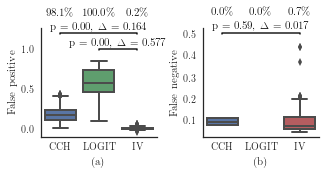

In [26]:
# False positive
fig, (ax_fp, ax_fn) = plt.subplots(1, 2, gridspec_kw={'wspace': 0.4})

sns.boxplot(data=fp.loc[:,include], palette=['b', 'g', 'r'], ax=ax_fp)
for key, pos_x, pos_y in zip(['CCH','LOGIT'], [0, 1], [1.2, 1.00]):
    case = fp.loc[:,['IV']].dropna().values.flatten()
    control = fp.loc[:,[key]].dropna().values.flatten()
    pval, observed_diff, diffs = permutation_resampling(case, control, 1000, statistic=np.median)
    txt = 'p = {:.2f}, $\\Delta$ = {:.3f}'.format(pval, observed_diff)
    label_diff(pos_x, 2, pos_y, txt, ax_fp)
N = fp.shape[0]
ypos = 1.4
for xpos, name in zip([0, 1, 2], include):
    text = '{:.1f}\%'.format((sum(abs(fp[name]) > TOL) / N) * 100)
    ax_fp.text(xpos, ypos, text, ha='center', va='bottom', color='k')
sns.despine(ax=ax_fp)
ax_fp.set_ylabel('False positive')

# False negative
sns.boxplot(data=fn.loc[:,include], palette=['b', 'g', 'r'], ax=ax_fn)
for key, pos_x, pos_y in zip(['CCH'], [0, 1], [.5, 0.9]):
    case = fn.loc[:,['IV']].dropna().values.flatten()
    control = fn.loc[:,[key]].dropna().values.flatten()
#     print(len(control))
    pval, observed_diff, diffs = permutation_resampling(case, control, 1000, statistic=np.nanmedian)
    txt = 'p = {:.2f}, $\\Delta$ = {:.3f}'.format(pval, observed_diff)
    label_diff(pos_x, 2, pos_y, txt, ax_fn)
N = analys.shape[0] / 100
for x, name in zip([0, 1, 2], include):
    text = '{:.1f}\%'.format(len(fn[name].dropna()) / tmp.shape[0])
    ax_fn.text(x, .58, text, ha='center', va='bottom', color='k')
sns.despine()
ax_fn.set_ylabel('False negative')

add_caption(ax=(ax_fp, ax_fn))
if save: savefig(plt.gcf(), 'false_estimate')